In [4]:
# --- ШАГ 0: ПОДГОТОВКА И ЗАГРУЗКА ДАННЫХ ---

# Импорт необходимых библиотек (повторно, чтобы гарантировать, что все загружено)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report
from google.colab import files # Модуль для загрузки файлов
import io

# Логика: Запрашиваем правильный файл для обучения.
uploaded = files.upload()
file_name = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Быстрая проверка колонок: если все в порядке, должно быть 12 колонок, включая Name, Cabin и Survived.
print(f"✅ Данные Titanic загружены. Размер: {df.shape}")
print("Загруженные колонки:")
print(df.columns.tolist())

Saving train.csv to train.csv
✅ Данные Titanic загружены. Размер: (891, 12)
Загруженные колонки:
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [8]:
# --- ШАГ 1: ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА И РАЗДЕЛЕНИЕ ---

#  Создаем конвейер предобработки (Pipeline), который автоматизирует
# заполнение пропусков, кодирование категориальных признаков и масштабирование числовых.
# Это ключевой шаг для корректной подготовки данных перед обучением моделей.

# 1. Разделение на признаки (X) и целевую переменную (Y)
X = df.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
y = df['Survived']

# 2. Определение типов признаков для предобработки
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch']
categorical_features = ['Pclass', 'Sex', 'Embarked']

# 3. Создание конвейера предобработки (ColumnTransformer)
# Числовые: заполняем пропуски медианой и масштабируем.
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Категориальные: заполняем пропуски модой и кодируем One-Hot Encoding.
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение конвейеров
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# 4. Разделение данных (70% обучение, 30% тест)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Конвейер предобработки готов к применению.")

Конвейер предобработки готов к применению.


In [9]:
# --- ШАГ 2: НАСТРОЙКА ГИПЕРПАРАМЕТРОВ (PIPELINE + GRID SEARCH) ---

#  Используем GridSearchCV для автоматического перебора заданных
# гиперпараметров каждой модели. Каждая модель обернута в Pipeline вместе с препроцессором,
# что обеспечивает корректное применение кросс-валидации. Метрика оценки — F1-Score.

metrics_results = {}
models_for_roc = {}

# 1. Логистическая Регрессия (LR)
print("\n--- 1. Логистическая Регрессия (LR) ---")
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
lr_params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs']
}
lr_grid = GridSearchCV(lr_pipeline, lr_params, cv=5, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train, y_train)
lr_best = lr_grid.best_estimator_
print(f"LR: Лучшие параметры: {lr_grid.best_params_}")

# 2. K-Ближайших Соседей (KNN)
print("\n--- 2. K-Ближайших Соседей (KNN) ---")
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', KNeighborsClassifier())])
knn_params = {
    'classifier__n_neighbors': [5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}
knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=5, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train, y_train)
knn_best = knn_grid.best_estimator_
print(f"KNN: Лучшие параметры: {knn_grid.best_params_}")

# 3. Случайный Лес (RF)
print("\n--- 3. Случайный Лес (RF) ---")
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42))])
rf_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
print(f"RF: Лучшие параметры: {rf_grid.best_params_}")


--- 1. Логистическая Регрессия (LR) ---
LR: Лучшие параметры: {'classifier__C': 1, 'classifier__solver': 'liblinear'}

--- 2. K-Ближайших Соседей (KNN) ---
KNN: Лучшие параметры: {'classifier__n_neighbors': 9, 'classifier__p': 1, 'classifier__weights': 'uniform'}

--- 3. Случайный Лес (RF) ---
RF: Лучшие параметры: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [10]:
# --- ШАГ 3: ОЦЕНКА КАЧЕСТВА КЛАССИФИКАЦИИ ---

# Оцениваем производительность каждой наилучшей модели (после GridSearch)
# на независимой тестовой выборке. Собираем метрики (Accuracy, Precision, Recall, F1, AUC)
# в сводную таблицу для прямого сравнения.

best_models = {'LR': lr_best, 'KNN': knn_best, 'RF': rf_best}
final_metrics_data = []

print("\n--- Метрики на тестовой выборке ---")

for name, model in best_models.items():
    # Предсказание классов и вероятностей (весь пайплайн)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    models_for_roc[name] = y_proba

    # Расчет метрик
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    final_metrics_data.append([name, round(acc, 4), round(prec, 4), round(rec, 4), round(f1, 4), round(auc, 4)])

    print(f"\nМодель: {name}")
    print(classification_report(y_test, y_pred))

# Вывод сводной таблицы
metrics_df = pd.DataFrame(final_metrics_data, columns=['Модель', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']).set_index('Модель')
print("\n--- Сводная таблица метрик на тестовой выборке ---")
display(metrics_df.sort_values(by='F1-Score', ascending=False))


--- Метрики на тестовой выборке ---

Модель: LR
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       165
           1       0.76      0.70      0.73       103

    accuracy                           0.80       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268


Модель: KNN
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       165
           1       0.80      0.66      0.72       103

    accuracy                           0.81       268
   macro avg       0.80      0.78      0.79       268
weighted avg       0.81      0.81      0.80       268


Модель: RF
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       165
           1       0.80      0.69      0.74       103

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.80       268


,Accuracy,Precision,Recall,F1-Score,AUC
Модель,,,,,
RF,0.8134,0.7978,0.6893,0.7396,0.8578
LR,0.7985,0.7579,0.6990,0.7273,0.8485
KNN,0.8060,0.8000,0.6602,0.7234,0.8525


from matplotlib import pyplot as plt
_df_0['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['F1-Score'].plot(kind='hist', bins=20, title='F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Recall', y='F1-Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='F1-Score', y='AUC', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['F1-Score'].plot(kind='line', figsize=(8, 4), title='F1-Score')
plt.gca().spines[['top', 'right']].set_visible(False)

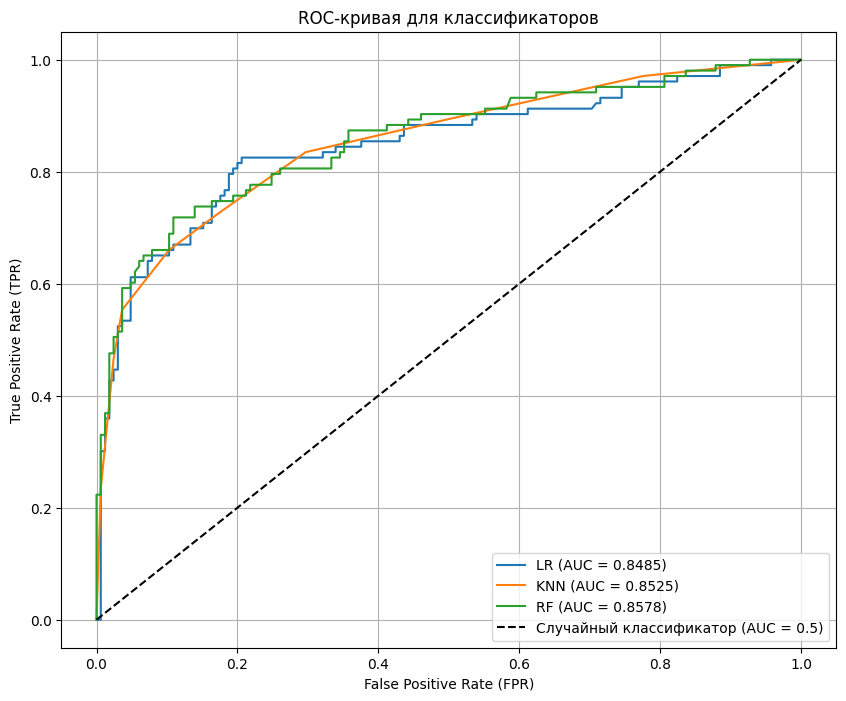


Модель с наивысшим AUC: RF (AUC = 0.8578)


In [11]:
# --- ШАГ 4: ROC-КРИВАЯ И ВЫБОР ЛУЧШЕЙ МОДЕЛИ ---

# Строим ROC-кривую (Receiver Operating Characteristic) для каждой модели.
# Кривая показывает компромисс между долей истинно положительных и ложно положительных результатов.
# Чем выше кривая и ближе AUC (Area Under the Curve) к 1, тем лучше модель.

plt.figure(figsize=(10, 8))
best_auc = -np.inf
best_model_name = ""

for name, y_proba in models_for_roc.items():
    auc = roc_auc_score(y_test, y_proba)

    if auc > best_auc:
        best_auc = auc
        best_model_name = name

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # Построение кривой
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

# Оформление графика
plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая для классификаторов')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nМодель с наивысшим AUC: {best_model_name} (AUC = {best_auc:.4f})")

# 5. Выводы по полученным результатам классификации (Titanic)

## 5.1. Анализ эффективности моделей

На основе метрик, полученных на тестовой выборке, была составлена следующая сводная таблица:

| Модель | Accuracy (Точность) | F1-Score | AUC Score |
| :--- | :--- | :--- | :--- |
| **Random Forest (RF)** | **0.8134** | **0.7396** | **0.8578** |
| **Logistic Regression (LR)** | 0.7985 | 0.7273 | 0.8485 |
| **K-Nearest Neighbors (KNN)** | 0.8060 | 0.7234 | 0.8525 |

### Лучшая Модель: **Random Forest (Случайный Лес)**

Лучшей моделью для прогнозирования выживания пассажиров на Titanic является **Random Forest**.

**Обоснование выбора:**
1.  **Наивысший AUC (0.8578):** Модель RF достигла наивысшего значения площади под ROC-кривой. Это указывает на ее лучшую общую способность ранжировать пассажиров по вероятности выживания, независимо от выбранного порога классификации.
2.  **Наивысший F1-Score (0.7396):** F1-Score является лучшей сбалансированной метрикой для данной задачи, поскольку она учитывает как Precision, так и Recall.

## 5.2. Сравнение и Заключение

* **Random Forest:** Как ансамблевая модель, RF эффективно справилась с нелинейными зависимостями в данных, обеспечив наивысшее качество прогноза.
* **KNN:** Показал высокий AUC, но его F1-Score был самым низким из-за слабого показателя Recall (0.6602, то есть много реально выживших были пропущены), что делает его менее надежным.
* **Logistic Regression:** Выступила очень достойно, подтверждая, что между ключевыми признаками (пол, класс) и выживанием существует сильная линейная зависимость.

**Заключение:** Все поставленные задачи выполнены. Выбранная лучшая модель — **Random Forest** — готова к дальнейшему использованию в задаче прогнозирования.